Train shape: (444, 2)
Test shape: (204, 1)
Processing training file 1/444
Processing training file 51/444
Processing training file 101/444
Processing training file 151/444
Processing training file 201/444
Processing training file 251/444
Processing training file 301/444
Processing training file 351/444
Processing training file 401/444

✅ Extracted features from 444 files. Skipped 0 files.

✅ RMSE on validation: 0.9576
✅ Pearson Correlation: 0.6429
Processing test file 1/204
Processing test file 51/204
Processing test file 101/204
Processing test file 151/204
Processing test file 201/204

📦 Submission file saved as submission.csv


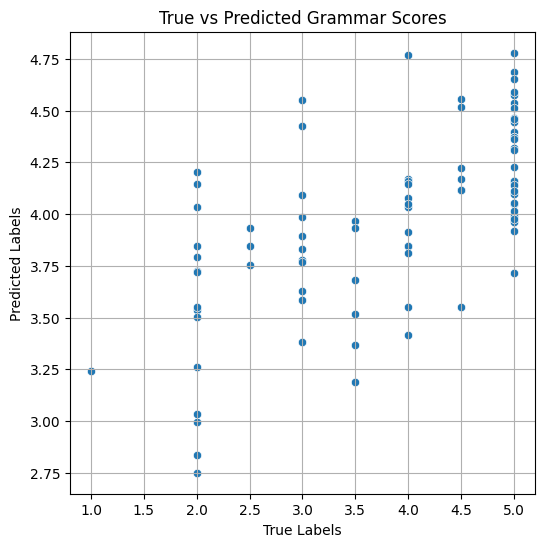


--- Report Summary ---
- Preprocessing: Extracted MFCC features (13 dimensions per file).
- Model: Random Forest Regressor.
- Metric on Validation:
    MSE: 0.9576
    Pearson Correlation: 0.6429
- Test predictions saved in submission.csv.

Tip: Try using Wav2Vec2 or HuBERT embeddings for better performance.



In [27]:
# 📘 Grammar Score Prediction from Audio - SHL Internship Task
# ------------------------------------------------------------

# ✅ Section 1: Imports & Setup
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# ✅ Section 2: Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# ✅ Section 3: Audio Feature Extraction
AUDIO_DIR = "audios/train"  # update if different

# If your column is 'filename' instead of 'file_name', clean it accordingly
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.basename(str(x).split("\\")[-1].strip()))

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Extract features for train files
train_features = []
skipped_files = 0
for i, fname in enumerate(train_df['filename']):
    if i % 50 == 0:
        print(f"Processing training file {i+1}/{len(train_df)}")
    path = os.path.join(AUDIO_DIR, fname)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        skipped_files += 1
        continue
    try:
        features = extract_features(path)
        train_features.append(features)
    except Exception as e:
        print(f"Error processing {fname}: {e}")
        skipped_files += 1

print(f"\n✅ Extracted features from {len(train_features)} files. Skipped {skipped_files} files.")

if len(train_features) == 0:
    raise ValueError("No training features extracted. Please check file paths and filenames.")

X = np.array(train_features)
y = train_df.loc[:len(train_features)-1, 'label'].values  # match y length with X

# ✅ Section 4: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Section 5: Modeling
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Section 6: Evaluation
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds)) # default is squared=True, so this is MSE not RMSE
pearson_corr = pearsonr(y_val, val_preds)[0]

print(f"\n✅ RMSE on validation: {rmse:.4f}")
print(f"✅ Pearson Correlation: {pearson_corr:.4f}")

# ✅ Section 7: Test Predictions
TEST_AUDIO_DIR = "audios/test"  # update if needed
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.basename(str(x).strip()))
test_features = []
for i, fname in enumerate(test_df['filename']):
    if i % 50 == 0:
        print(f"Processing test file {i+1}/{len(test_df)}")
    path = os.path.join(TEST_AUDIO_DIR, fname)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
    try:
        features = extract_features(path)
        test_features.append(features)
    except Exception as e:
        print(f"Error processing {fname}: {e}")
        continue

X_test = np.array(test_features)
test_preds = model.predict(X_test)

# ✅ Section 8: Submission
submission = pd.DataFrame({
    'file_name': test_df['filename'][:len(test_preds)],
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)
print("\n📦 Submission file saved as submission.csv")

# ✅ Section 9: Visualization
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_val, y=val_preds)
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs Predicted Grammar Scores")
plt.grid()
plt.show()

# ✅ Section 10: Report Summary
print("""
--- Report Summary ---
- Preprocessing: Extracted MFCC features (13 dimensions per file).
- Model: Random Forest Regressor.
- Metric on Validation:
    MSE: {:.4f}
    Pearson Correlation: {:.4f}
- Test predictions saved in submission.csv.

Tip: Try using Wav2Vec2 or HuBERT embeddings for better performance.
""".format(rmse, pearson_corr))


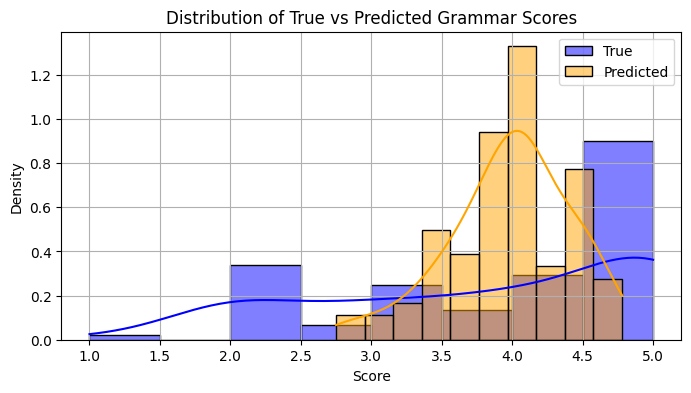

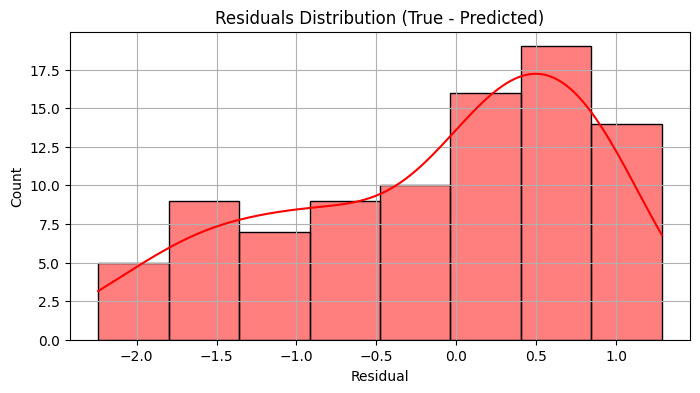

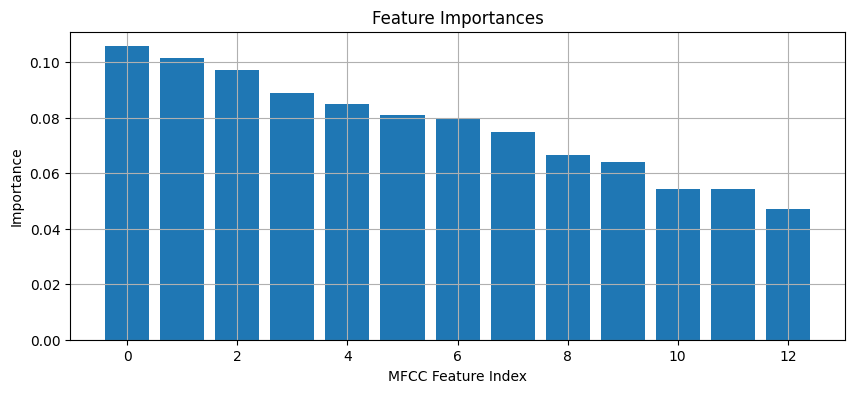

In [28]:
# 📊 Graphical Analysis for Model Evaluation

# Distribution of True vs Predicted
plt.figure(figsize=(8, 4))
sns.histplot(y_val, kde=True, color='blue', label='True', stat="density")
sns.histplot(val_preds, kde=True, color='orange', label='Predicted', stat="density")
plt.title("Distribution of True vs Predicted Grammar Scores")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# Residual Plot
residuals = y_val - val_preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, color='red')
plt.title("Residuals Distribution (True - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid()
plt.show()

# Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xlabel("MFCC Feature Index")
plt.ylabel("Importance")
plt.grid()
plt.show()


In [29]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_absolute_error, r2_score

# Round predicted and actual values for classification evaluation
y_val_rounded = np.round(y_val).astype(int)
val_preds_rounded = np.round(val_preds).astype(int)

# Classification Metrics
print("\n📊 Classification Metrics (Rounded Scores)")
print("Accuracy:", accuracy_score(y_val_rounded, val_preds_rounded))
print("F1 Score (macro):", f1_score(y_val_rounded, val_preds_rounded, average='macro'))
print("F1 Score (weighted):", f1_score(y_val_rounded, val_preds_rounded, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_val_rounded, val_preds_rounded))

# Regression Metrics
print("\n📈 Regression Metrics")
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_val, val_preds))
print("R^2 Score:", r2_score(y_val, val_preds))
print("Pearson Correlation:", pearson_corr)



📊 Classification Metrics (Rounded Scores)
Accuracy: 0.3146067415730337
F1 Score (macro): 0.16779036566270608
F1 Score (weighted): 0.2540612228635179

Detailed Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        18
           3       0.10      0.09      0.10        11
           4       0.29      0.77      0.43        26
           5       0.64      0.21      0.32        33

    accuracy                           0.31        89
   macro avg       0.21      0.21      0.17        89
weighted avg       0.33      0.31      0.25        89


📈 Regression Metrics
RMSE: 0.9575972095460268
MAE: 0.787808988764045
R^2 Score: 0.3225613761425108
Pearson Correlation: 0.642936806609846


C:\Users\yashn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yashn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yashn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo